## 📚 PENJELASAN KONFIGURASI - RESNET18

### ⚠️ CATATAN PENTING
**ResNet18 TIDAK tersedia di `tensorflow.keras.applications`!**

Notebook ini menggunakan **Custom ResNet18** yang dibangun manual dengan Keras layers.
Model ini **TIDAK memiliki pre-trained weights** dari ImageNet.

| Model | Parameter | Pre-trained? | Layers |
|-------|-----------|--------------|--------|
| ResNet18 (Custom) | ~11.2 juta | ❌ Tidak | ~60 |
| ResNet50 (Keras) | ~25.6 juta | ✅ Ya | ~175 |

---

### 1. Label Smoothing
Label smoothing mengubah target dari "keras" (hard) menjadi "lembut" (soft):

```
TANPA Label Smoothing (α = 0):
Target Kelas 2: [0, 1, 0, 0]  ← Model DIPAKSA 100% yakin

DENGAN Label Smoothing (α = 0.1):
Target Kelas 2: [0.025, 0.925, 0.025, 0.025]  ← Model BOLEH sedikit ragu
```

---

### 2. Class Weights Moderat (Sqrt Balanced)
Memberikan bobot berbeda per kelas dalam perhitungan loss:

| Kelas | Data Unik | Weight | Efek |
|-------|-----------|--------|------|
| 1 | 128 | 1.18 | Sedikit boost |
| 2 | 256 | 0.83 | Dikurangi (mayoritas) |
| 3 | 161 | 1.05 | Hampir netral |
| 4 | 63 | 1.67 | Di-boost (minoritas) |

---

### 3. Perbedaan Parameter dengan ResNet50

| Parameter | ResNet50 | ResNet18 | Alasan |
|-----------|----------|----------|--------|
| FINE_TUNE_AT | 140 | 40 | ResNet18 hanya ~60 layers |
| LR_PHASE_1 | 1e-4 | 1e-3 | Training from scratch butuh LR lebih tinggi |
| LR_PHASE_2 | 5e-5 | 1e-4 | Fine-tuning lebih agresif |
| EPOCHS | Lebih sedikit | Lebih banyak | Tanpa pre-trained butuh lebih lama |

In [30]:
# =================================================================================================
# 1. SETUP & LOAD DATA (MENGGUNAKAN PREPROCESS YANG SUDAH ADA)
# =================================================================================================

# Memanggil file preprocess_resnet18.ipynb agar variabel train_ds, val_ds, test_ds tersedia
# Pastikan file preprocess_resnet18.ipynb berada di folder yang sama
%run preprocess_resnet18.ipynb

import os
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Dropout, Input,
    Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import AdamW, SGD, RMSprop, Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
from datetime import datetime

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, gamma=2.0, name='focal_loss'):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        # Clip predictions
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        ce = -y_true * tf.math.log(y_pred)
        
        # Calculate focal weight
        pt = y_true * y_pred
        pt = tf.reduce_sum(pt, axis=-1, keepdims=True)
        focal_weight = tf.pow(1.0 - pt, self.gamma)
        
        # Apply focal loss
        focal_loss = self.alpha * focal_weight * tf.reduce_sum(ce, axis=-1, keepdims=True)
        
        return tf.reduce_mean(focal_loss)

TensorFlow version: 2.20.0
TensorFlow Hub version: 0.16.1
GPU Available: []
Konfigurasi:
  - Image Size: 224x224
  - Batch Size: 32
  - Num Classes: 4
  - Data Path: dataset_final
PROSES PEMUATAN DATASET

[1/3] Memuat dataset_final\train
Found 1400 files belonging to 4 classes.

[2/3] Memuat dataset_final\val
Found 131 files belonging to 4 classes.

[3/3] Memuat dataset_final\test
Found 132 files belonging to 4 classes.

INFORMASI KELAS & MAPPING
Kelas ditemukan: ['1', '2', '3', '4']

Index      | Folder     | Kandungan Aflatoksin
--------------------------------------------------
0          | 1          | 1 PPB
1          | 2          | 2 PPB
2          | 3          | 3 PPB
3          | 4          | 4 PPB
Setting up data augmentation...
✓ RandomFlip (horizontal)
✓ RandomRotation (±1.6°)

❌ RandomBrightness - TIDAK DIGUNAKAN (mengubah nilai PPB)
❌ RandomContrast - TIDAK DIGUNAKAN (mengubah nilai PPB)
Fungsi preprocessing untuk ResNet18 telah dibuat.

Normalisasi yang digunakan:
  - Inp

In [31]:
# =================================================================================================
# 1.5 CUSTOM RESNET18 BUILDER
# =================================================================================================
# ResNet18 tidak tersedia di keras.applications, jadi kita bangun manual

def basic_block(x, filters, stride=1, downsample=None, name=None):
    """
    Basic Block untuk ResNet18/34
    Struktur: x → Conv3x3 → BN → ReLU → Conv3x3 → BN → Add(x) → ReLU
    """
    identity = x
    
    # First conv
    out = Conv2D(filters, 3, strides=stride, padding='same', 
                 use_bias=False, name=f'{name}_conv1')(x)
    out = BatchNormalization(name=f'{name}_bn1')(out)
    out = Activation('relu', name=f'{name}_relu1')(out)
    
    # Second conv
    out = Conv2D(filters, 3, strides=1, padding='same', 
                 use_bias=False, name=f'{name}_conv2')(out)
    out = BatchNormalization(name=f'{name}_bn2')(out)
    
    # Shortcut connection
    if downsample is not None:
        identity = downsample(x)
    
    out = Add(name=f'{name}_add')([out, identity])
    out = Activation('relu', name=f'{name}_relu2')(out)
    
    return out

def make_layer(x, filters, blocks, stride=1, name=None):
    """
    Membuat layer yang terdiri dari beberapa basic blocks
    """
    downsample = None
    
    # Jika stride != 1 atau jumlah filter berubah, perlu downsample
    if stride != 1 or x.shape[-1] != filters:
        downsample = Sequential([
            Conv2D(filters, 1, strides=stride, use_bias=False),
            BatchNormalization()
        ], name=f'{name}_downsample')
    
    # First block (mungkin perlu downsample)
    x = basic_block(x, filters, stride, downsample, name=f'{name}_block1')
    
    # Remaining blocks
    for i in range(1, blocks):
        x = basic_block(x, filters, name=f'{name}_block{i+1}')
    
    return x

def build_resnet18_base(input_shape=(224, 224, 3)):
    """
    Membangun base ResNet18 (tanpa classification head)
    
    Struktur:
    - Conv1: 7x7, 64 filters, stride 2
    - MaxPool: 3x3, stride 2  
    - Layer1: 2 basic blocks, 64 filters
    - Layer2: 2 basic blocks, 128 filters, stride 2
    - Layer3: 2 basic blocks, 256 filters, stride 2
    - Layer4: 2 basic blocks, 512 filters, stride 2
    - Global Average Pooling → Output: 512-dim vector
    
    Total ~60 layers
    """
    inputs = Input(shape=input_shape, name='input')
    
    # Initial convolution (conv1)
    x = Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)
    x = MaxPooling2D(3, strides=2, padding='same', name='maxpool')(x)
    
    # Residual layers
    x = make_layer(x, 64, 2, stride=1, name='layer1')   # conv2_x: 2 blocks
    x = make_layer(x, 128, 2, stride=2, name='layer2')  # conv3_x: 2 blocks
    x = make_layer(x, 256, 2, stride=2, name='layer3')  # conv4_x: 2 blocks
    x = make_layer(x, 512, 2, stride=2, name='layer4')  # conv5_x: 2 blocks
    
    # Global average pooling
    x = GlobalAveragePooling2D(name='avgpool')(x)
    
    model = Model(inputs=inputs, outputs=x, name='resnet18_base')
    return model

# Test build dan tampilkan info
print("="*60)
print("CUSTOM RESNET18 ARCHITECTURE")
print("="*60)
print("\nStruktur ResNet18:")
print("  - Conv1: 7x7, 64 filters, stride 2")
print("  - MaxPool: 3x3, stride 2")
print("  - Layer1: 2 basic blocks × 64 filters")
print("  - Layer2: 2 basic blocks × 128 filters")
print("  - Layer3: 2 basic blocks × 256 filters")
print("  - Layer4: 2 basic blocks × 512 filters")
print("  - Global Average Pooling → 512-dim")

_test_base = build_resnet18_base()
print(f"\n✓ Total layers in base model: {len(_test_base.layers)}")
print(f"✓ Base model parameters: {_test_base.count_params():,}")
del _test_base

CUSTOM RESNET18 ARCHITECTURE

Struktur ResNet18:
  - Conv1: 7x7, 64 filters, stride 2
  - MaxPool: 3x3, stride 2
  - Layer1: 2 basic blocks × 64 filters
  - Layer2: 2 basic blocks × 128 filters
  - Layer3: 2 basic blocks × 256 filters
  - Layer4: 2 basic blocks × 512 filters
  - Global Average Pooling → 512-dim

✓ Total layers in base model: 65
✓ Base model parameters: 11,186,112


In [32]:
# =================================================================================================
# 2. KONFIGURASI EKSPERIMEN (UBAH PARAMETER DI SINI SETIAP KALI RUNNING)
# =================================================================================================
# Ini adalah "Control Panel" kamu. Ubah angka di sini, lalu Run All.

# --- Parameter Arsitektur Model ---
LAYER_CONFIG = [512, 256]   # Konfigurasi layer Dense bertingkat
                            # Lebih sederhana dari ResNet50 karena model lebih kecil
DROPOUT_RATE = 0.5          # 0.5 artinya 50% neuron dimatikan acak saat training
FINE_TUNE_AT = 20           # Layer ResNet18 (total ~60) mulai dari mana kita 'cairkan'
                            # ResNet18 lebih kecil, jadi fine-tune dari layer lebih awal

# --- Parameter Training Phase 1 (Feature Extraction - Base Model Beku) ---
LR_PHASE_1 = 1e-3           # Learning Rate lebih tinggi karena training from scratch
EPOCHS_PHASE_1 = 50         # Epoch lebih banyak karena tanpa pre-trained weights

# --- Parameter Training Phase 2 (Fine Tuning - Base Model Cair Sebagian) ---
LR_PHASE_2 = 5e-4           # LR untuk fine-tuning
EPOCHS_PHASE_2 = 50         # Epoch lanjutan

# --- Lainnya ---
BATCH_SIZE = 32             # Jumlah gambar yang diproses sekali jalan
OPTIMIZER_NAME = 'Adam'     # Pilihan: 'Adam', 'AdamW', 'SGD', 'RMSprop'
LOG_FILE_PATH = 'experiment_log_resnet18.csv'  # Nama file untuk menyimpan hasil
MODEL_SAVE_PATH = 'best_resnet18_aflatoxin.keras'

# --- Regularisasi ---
LABEL_SMOOTHING = 0         # Label smoothing (0 = off)

# --- Class Weights Moderat (Sqrt Balanced berdasarkan foto UNIK) ---
USE_CLASS_WEIGHTS = True    # Set False jika ingin menonaktifkan
CLASS_WEIGHTS = {
    0: 1.18,    # Kelas 1 (128 foto unik)
    1: 0.83,    # Kelas 2 (256 foto unik)
    2: 1.05,    # Kelas 3 (161 foto unik)
    3: 1.67,    # Kelas 4 (63 foto unik)
}

# --- Print Konfigurasi ---
print("="*60)
print("KONFIGURASI EKSPERIMEN RESNET18")
print("="*60)
print(f"\n📐 Arsitektur:")
print(f"   Layer Config: {LAYER_CONFIG}")
print(f"   Dropout: {DROPOUT_RATE}")
print(f"   Fine-tune at: {FINE_TUNE_AT}")
print(f"\n📈 Phase 1:")
print(f"   LR: {LR_PHASE_1}, Epochs: {EPOCHS_PHASE_1}")
print(f"\n📈 Phase 2:")
print(f"   LR: {LR_PHASE_2}, Epochs: {EPOCHS_PHASE_2}")
print(f"\n⚖️ Class Weights: {USE_CLASS_WEIGHTS}")
if USE_CLASS_WEIGHTS:
    print(f"   {CLASS_WEIGHTS}")

KONFIGURASI EKSPERIMEN RESNET18

📐 Arsitektur:
   Layer Config: [512, 256]
   Dropout: 0.5
   Fine-tune at: 20

📈 Phase 1:
   LR: 0.001, Epochs: 50

📈 Phase 2:
   LR: 0.0005, Epochs: 50

⚖️ Class Weights: True
   {0: 1.18, 1: 0.83, 2: 1.05, 3: 1.67}


In [33]:
# =================================================================================================
# 3. MEMBANGUN MODEL (ARSITEKTUR RESNET18)
# =================================================================================================

def build_model_experiment():
    # Menggunakan Custom ResNet18 sebagai base
    # CATATAN: Tidak ada pre-trained weights!
    base_model = build_resnet18_base(input_shape=(224, 224, 3))
    
    # Freeze Base Model: Kita kunci bobot ResNet agar tidak berubah di Fase 1
    base_model.trainable = False

    x = base_model.output
    
    for units in LAYER_CONFIG:
        # Tambah Dense Layer
        x = Dense(units, activation='relu')(x)
        if DROPOUT_RATE > 0:
            x = Dropout(DROPOUT_RATE)(x)
    
    # Output Layer (4 Kelas)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model, base_model

# Inisialisasi Model
model, base_model = build_model_experiment()

# Setup Optimizer Dinamis sesuai Konfigurasi
if OPTIMIZER_NAME.lower() == 'adam':
    opt = Adam(learning_rate=LR_PHASE_1)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt = SGD(learning_rate=LR_PHASE_1, momentum=0.9)
elif OPTIMIZER_NAME.lower() == 'adamw':
    opt = AdamW(learning_rate=LR_PHASE_1)
else:
    opt = RMSprop(learning_rate=LR_PHASE_1)

model.compile(
    optimizer=opt, 
    loss=FocalLoss(alpha=1.0, gamma=2.0), 
    metrics=['accuracy']
)

print(f"\n[INFO] Model dibangun dengan Optimizer: {OPTIMIZER_NAME} | LR Awal: {LR_PHASE_1}")
print(f"✓ Optimizer: {OPTIMIZER_NAME} | LR Awal: {LR_PHASE_1}")
print(f"✓ Loss: Focal Loss (alpha=1.0, gamma=2.0)")
print(f"✓ Metrics: accuracy")
print(f"Model compiled successfully!")
print(f"\nTotal parameters: {model.count_params():,}")
print(f"Base model layers: {len(base_model.layers)}")


[INFO] Model dibangun dengan Optimizer: Adam | LR Awal: 0.001
✓ Optimizer: Adam | LR Awal: 0.001
✓ Loss: Focal Loss (alpha=1.0, gamma=2.0)
✓ Metrics: accuracy
Model compiled successfully!

Total parameters: 11,581,124
Base model layers: 65


In [36]:
print("Setting up training callbacks...")

# Training callbacks for better training control
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,        # Lebih sabar karena training from scratch
        mode='max',
        restore_best_weights=True, 
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-8,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("✓ EarlyStopping (monitor='val_accuracy', patience=15)")
print("✓ ReduceLROnPlateau (factor=0.5, patience=8)")
print(f"✓ ModelCheckpoint (save to: {MODEL_SAVE_PATH})")

Setting up training callbacks...
✓ EarlyStopping (monitor='val_accuracy', patience=15)
✓ ReduceLROnPlateau (factor=0.5, patience=8)
✓ ModelCheckpoint (save to: best_resnet18_aflatoxin.keras)


In [37]:
# =================================================================================================
# 4. TRAINING PHASE 1 (WARM UP)
# =================================================================================================
# Tujuannya agar layer Dense baru beradaptasi dengan fitur dari ResNet sebelum ResNet-nya kita utak-atik.

active_class_weights = CLASS_WEIGHTS if USE_CLASS_WEIGHTS else None

print(f"\n[INFO] === PHASE 1: Training Head Only ({EPOCHS_PHASE_1} Epochs) ===")
if USE_CLASS_WEIGHTS:
    print(f"✓ Class Weights aktif: {CLASS_WEIGHTS}")

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE_1,
    callbacks=callbacks,
    class_weight=active_class_weights,
    verbose=1
)

p1_best_val_acc = max(history_1.history['val_accuracy'])
print(f"\n✓ Phase 1 Selesai!")
print(f"✓ Best Validation Accuracy Phase 1: {p1_best_val_acc:.4f}")


[INFO] === PHASE 1: Training Head Only (50 Epochs) ===
✓ Class Weights aktif: {0: 1.18, 1: 0.83, 2: 1.05, 3: 1.67}
Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3200 - loss: 0.8835
Epoch 1: val_accuracy improved from None to 0.16794, saving model to best_resnet18_aflatoxin.keras

Epoch 1: finished saving model to best_resnet18_aflatoxin.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.3257 - loss: 0.8762 - val_accuracy: 0.1679 - val_loss: 0.8130 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3489 - loss: 0.8652
Epoch 2: val_accuracy did not improve from 0.16794
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.3486 - loss: 0.8625 - val_accuracy: 0.1679 - val_loss: 0.8253 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3322 - loss: 0.8770
Epoch 3: val_accuracy did not improve from 0.16794
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.3436 - loss: 0.8697 

In [38]:
# =================================================================================================
# 5. TRAINING PHASE 2 (FINE TUNING)
# =================================================================================================
# Sekarang kita cairkan sebagian layer ResNet18 untuk menyesuaikan fitur spesifik

# --- LANGKAH PENTING: MUAT BOBOT TERBAIK DARI FASE 1 ---
try:
    model.load_weights(MODEL_SAVE_PATH)
    print("✅ Bobot terbaik dari Phase 1 berhasil dimuat.")
except Exception as e:
    print(f"❌ Peringatan: Gagal memuat bobot dari {MODEL_SAVE_PATH}. Error: {e}")
    print("   Melanjutkan dengan bobot terakhir Phase 1.")
    
print(f"\n[INFO] === PHASE 2: Fine Tuning (Start Layer {FINE_TUNE_AT}, {EPOCHS_PHASE_2} Epochs) ===")

total_epochs = EPOCHS_PHASE_1 + EPOCHS_PHASE_2
base_model.trainable = True  # Unfreeze base model

# Freeze ulang layer-layer awal (Low-level features seperti garis/sudut biasanya sudah bagus)
# Kita hanya ingin melatih layer-layer akhir (High-level features)
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False
    
# Hitung jumlah layer yang di-unfreeze
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"✓ {trainable_count} layers di-unfreeze untuk fine-tuning")

# Compile ulang wajib dilakukan setelah mengubah trainable status
# Gunakan LR yang lebih kecil untuk fine-tuning
if OPTIMIZER_NAME.lower() == 'adam':
    opt_ft = Adam(learning_rate=LR_PHASE_2)
elif OPTIMIZER_NAME.lower() == 'sgd':
    opt_ft = SGD(learning_rate=LR_PHASE_2, momentum=0.9)
elif OPTIMIZER_NAME.lower() == 'adamw':
    opt_ft = AdamW(learning_rate=LR_PHASE_2)
else:
    opt_ft = RMSprop(learning_rate=LR_PHASE_2)

model.compile(
    optimizer=opt_ft, 
    loss=FocalLoss(alpha=1.0, gamma=2.0), 
    metrics=['accuracy'])

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=len(history_1.history['loss']),
    epochs=total_epochs,
    callbacks=callbacks,
    class_weight=active_class_weights,
    verbose=1
)

p2_best_val_acc = max(history_2.history['val_accuracy'])
print(f"\n✓ Phase 2 Selesai!")
print(f"✓ Best Validation Accuracy Phase 2: {p2_best_val_acc:.4f}")

✅ Bobot terbaik dari Phase 1 berhasil dimuat.

[INFO] === PHASE 2: Fine Tuning (Start Layer 20, 50 Epochs) ===
✓ 45 layers di-unfreeze untuk fine-tuning
Epoch 43/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.2508 - loss: 14.2817
Epoch 43: val_accuracy did not improve from 0.18321
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 596ms/step - accuracy: 0.2500 - loss: 14.2549 - val_accuracy: 0.1069 - val_loss: 14.3955 - learning_rate: 5.0000e-04
Epoch 44/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.2508 - loss: 14.2817
Epoch 44: val_accuracy did not improve from 0.18321
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 586ms/step - accuracy: 0.2500 - loss: 14.2549 - val_accuracy: 0.1069 - val_loss: 14.3955 - learning_rate: 5.0000e-04
Epoch 45/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.2508 - loss: 14.2817
Epoch 45: val_accuracy did not improve from 0.18321
44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step - accuracy: 0.2500 - loss: 14.2549 - val_accuracy: 0.1069 - val_loss: 14.3955 - learni


[INFO] Melakukan Evaluasi Menyeluruh...


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 102 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✓ Best model loaded from best_resnet18_aflatoxin.keras
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000028812A57100> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step

Confusion Matrix:
[[10  3  1 14]
 [ 4  4  5 42]
 [ 2  1  3 29]
 [ 1  0  1 12]]
Classification Report
              precision    recall  f1-s

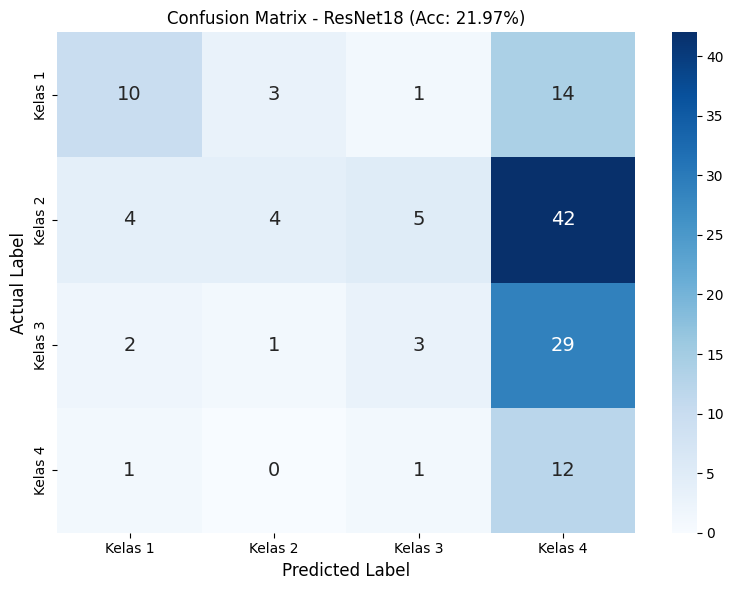

In [ ]:
# =================================================================================================
# 6. EVALUASI DAN METRIK (OTOMATIS)
# =================================================================================================
print("\n[INFO] Melakukan Evaluasi Menyeluruh...")

# Load best model
try:
    model.load_weights(MODEL_SAVE_PATH)
    print(f"✓ Best model loaded from {MODEL_SAVE_PATH}")
except:
    print("⚠️ Using current model weights")

# Prediksi (menghasilkan probabilitas, misal [0.1, 0.8, 0.05, 0.05])
Y_pred_probs = model.predict(test_ds, verbose=1)

# Ambil kelas dengan probabilitas tertinggi
y_pred = np.argmax(Y_pred_probs, axis=1)

# Label asli (Ground Truth)
y_true_onehot = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true_onehot, axis=1)

class_names = ['Kelas 1', 'Kelas 2', 'Kelas 3', 'Kelas 4']

# --- Metrik 1: Akurasi Global ---
test_acc = accuracy_score(y_true, y_pred)

# --- Metrik 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
cm_str = str(cm.tolist())
print("\nConfusion Matrix:")
print(cm)

# --- Metrik 3: Confidence Statistics ---
confidence_scores = np.max(Y_pred_probs, axis=1)
avg_conf = np.mean(confidence_scores)
min_conf = np.min(confidence_scores)
std_conf = np.std(confidence_scores)

# --- Metrik 4: Precision, Recall, F1 Per Kelas ---
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
print("=" * 60)
print("Classification Report")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print(f"✅ Akurasi Test Akhir: {test_acc*100:.2f}%")
print(f"✅ Rata-rata Confidence: {avg_conf*100:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Confusion Matrix
plot_folder = "history_plots_RN18" 
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_filename = f"cm_resnet18_{current_time_str}_Acc{test_acc*100:.1f}.png"
plot_filepath = os.path.join(plot_folder, plot_filename)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})
plt.title(f'Confusion Matrix - ResNet18 (Acc: {test_acc*100:.2f}%)')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

plt.savefig(plot_filepath, dpi=300, bbox_inches='tight')
print(f"\n🖼️ Gambar Confusion Matrix tersimpan di: {plot_filepath}")

plt.show()

In [40]:
# =================================================================================================
# 7. SISTEM PENYIMPANAN LOG (AUTO-CSV)
# =================================================================================================
# Bagian ini yang akan menyimpan "Jejak Percobaan" kamu selamanya.

# Dictionary data untuk satu baris CSV
log_data = {
    # Waktu
    "Timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    
    # Model Info
    "Model": "ResNet18 (Custom)",
    
    # Parameter Setup
    "Optimizer": OPTIMIZER_NAME,
    "Batch_Size": BATCH_SIZE,
    "Layer_Config": str(LAYER_CONFIG),
    "Dropout": DROPOUT_RATE,
    "Fine_Tune_At": FINE_TUNE_AT,
    
    # Parameter Training
    "LR_Phase_1": LR_PHASE_1,
    "Epochs_P1": EPOCHS_PHASE_1,
    "LR_Phase_2": LR_PHASE_2,
    "Epochs_P2": EPOCHS_PHASE_2,
    "Label_Smoothing": LABEL_SMOOTHING,
    "Use_Class_Weights": USE_CLASS_WEIGHTS,
    
    # Hasil Evaluasi Global
    "Accuracy": round(test_acc, 4),
    "Val_Acc_P1": round(p1_best_val_acc, 4),
    "Val_Acc_P2": round(p2_best_val_acc, 4),
    "Avg_Confidence": round(avg_conf, 4),
    "Min_Confidence": round(min_conf, 4),
    "Std_Confidence": round(std_conf, 4),
    "Confusion_Matrix": cm_str
}

# Loop otomatis untuk mengambil Precision/Recall/F1 tiap kelas
for label in class_names:
    metrics = report[label]
    log_data[f"Class_{label}_Prec"] = round(metrics['precision'], 4)
    log_data[f"Class_{label}_Rec"] = round(metrics['recall'], 4)
    log_data[f"Class_{label}_F1"] = round(metrics['f1-score'], 4)

# Buat DataFrame (1 baris)
df_new_log = pd.DataFrame([log_data])

# Logika Penyimpanan: Append jika file ada, Write jika belum ada
if not os.path.exists(LOG_FILE_PATH):
    df_new_log.to_csv(LOG_FILE_PATH, index=False)
    print(f"\n[SAVE] File log baru dibuat: {LOG_FILE_PATH}")
else:
    df_new_log.to_csv(LOG_FILE_PATH, mode='a', header=False, index=False)
    print(f"\n[SAVE] Hasil percobaan berhasil ditambahkan ke: {LOG_FILE_PATH}")

print("="*60)
print("PROSES SELESAI. SILAKAN UBAH PARAMETER DI ATAS UNTUK PERCOBAAN BERIKUTNYA.")
print("="*60)


[SAVE] Hasil percobaan berhasil ditambahkan ke: experiment_log_resnet18.csv
PROSES SELESAI. SILAKAN UBAH PARAMETER DI ATAS UNTUK PERCOBAAN BERIKUTNYA.
